<a href="https://colab.research.google.com/github/oenereaty/MP2024/blob/main/MP2024_wk12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports 및 데이터 다운

In [1]:
pip install datasets evaluate

In [2]:
import numpy as np
import pandas as pd
import zipfile
import os
import PIL.Image
import matplotlib.pyplot as plt
#---#
import datasets
import transformers
import torchvision.transforms
import evaluate
import torch

In [3]:
with zipfile.ZipFile('aerial-cactus-identification.zip', 'r') as z:
    z.extractall('./data')

In [4]:
with zipfile.ZipFile('./data/test.zip', 'r') as z_test: # data라는 폴더에 test.zip으로 압축풀기
    z_test.extractall('./data')
with zipfile.ZipFile('./data/train.zip', 'r') as z_train:
    z_train.extractall('./data')

# 코드 살펴보기

In [5]:
train_csv = pd.read_csv("./data/train.csv")
train_csv

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1
...,...,...
17495,ffede47a74e47a5930f81c0b6896479e.jpg,0
17496,ffef6382a50d23251d4bc05519c91037.jpg,1
17497,fff059ecc91b30be5745e8b81111dc7b.jpg,1
17498,fff43acb3b7a23edcc4ae937be2b7522.jpg,0


In [6]:
test_csv = pd.read_csv("./data/sample_submission.csv")
test_csv

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5
...,...,...
3995,ffaafd0c9f2f0e73172848463bc2e523.jpg,0.5
3996,ffae37344310a1549162493237d25d3f.jpg,0.5
3997,ffbd469c56873d064326204aac546e0d.jpg,0.5
3998,ffcb76b7d47f29ece11c751e5f763f52.jpg,0.5


`test`에는 라벨이 존재하지 않음

# `logits`의 이해

In [7]:
logits = np.array(
    [[ 2.7346244, -3.1177292],
     [ 2.7103324, -3.1362345],
     [ 2.7464483, -3.0521457],
     [ 2.7195318, -3.122628 ],
     [ 2.7138977, -3.1041346],
     [ 2.7398622, -3.1098123],
     [ 0.0657177, -0.0930362],
     [-2.7668718,  3.0918367]]
)
logits

array([[ 2.7346244, -3.1177292],
       [ 2.7103324, -3.1362345],
       [ 2.7464483, -3.0521457],
       [ 2.7195318, -3.122628 ],
       [ 2.7138977, -3.1041346],
       [ 2.7398622, -3.1098123],
       [ 0.0657177, -0.0930362],
       [-2.7668718,  3.0918367]])

1. 8개의 이미지가 있다고 가정

2. 1번째 observation, 2번째 observation... 8번째 observation 존재

3. 각각의 observation 의 왼쪽 숫자는 `label=0`이라고 생각하는 정도, 오른쪽 숫자는 `label=1`이라고 생각하는 정도

로짓값은 일반적으로 `(n,k)`의 차원을 가지며 여기에서 `n`은 observation의 숫자, `k`는 클래스의 숫자를 의미한다. 위에 작성한 예제의 경우, `n`=8, `k`=2 이다. (`k`가 2인 이유는 '선인장이 존재함 or 존재하지 않음' 이기 때문임)

In [8]:
for u in logits:
    u1, u2 = u
    if u1 > u2:
        prediction = 0
    else:
        prediction = 1
    print(prediction)

0
0
0
0
0
0
0
1


⇑ `logits`을 토대로 0인지 1인지 구별하는 코드

In [9]:
logits.argmax(axis=1)

array([0, 0, 0, 0, 0, 0, 0, 1])

**???: !!!!나는 퍼센티지로 보고 싶은데!!!!**

In [10]:
for u in logits:
    u1,u2 = u
    p1 = np.exp(u1) / (np.exp(u1)+np.exp(u2))
    p2 = np.exp(u2) / (np.exp(u1)+np.exp(u2))
    prediction_scores = [p1,p2]
    print(prediction_scores)

[0.9971351022231982, 0.0028648977768018545]
[0.9971185237682113, 0.0028814762317887605]
[0.9969773496339113, 0.0030226503660887583]
[0.9971058336243687, 0.0028941663756314024]
[0.997035364944602, 0.0029646350553980375]
[0.9971274386623321, 0.002872561337667959]
[0.5396053294830294, 0.4603946705169706]
[0.0028468010295870897, 0.997153198970413]


In [11]:
torch.tensor(logits).softmax(dim=1)

# numpy에는 없지만, torch에는 softmax라는 함수가 있다. 굳이 for문 써가면서 구하지 않아도 된다.

tensor([[0.9971, 0.0029],
        [0.9971, 0.0029],
        [0.9970, 0.0030],
        [0.9971, 0.0029],
        [0.9970, 0.0030],
        [0.9971, 0.0029],
        [0.5396, 0.4604],
        [0.0028, 0.9972]], dtype=torch.float64)

In [12]:
0.9971351022231982 +  0.0028648977768018545

1.0

# 평가지표

## accuracy 계산

In [13]:
logits = np.array(
    [[ 2.7346244, -3.1177292],
     [ 2.7103324, -3.1362345],
     [ 2.7464483, -3.0521457],
     [ 2.7195318, -3.122628 ],
     [ 2.7138977, -3.1041346],
     [ 2.7398622, -3.1098123],
     [ 0.0657177, -0.0930362],
     [-2.7668718,  3.0918367]]
)
references = labels = np.array([0,0,0,0,0,0,1,1])

In [14]:
predictions = logits.argmax(axis=1)
predictions

array([0, 0, 0, 0, 0, 0, 0, 1])

In [15]:
references

array([0, 0, 0, 0, 0, 0, 1, 1])

`predictions`와 `references=labels`의 값이 다른 게 있는데?

In [16]:
## 인공지능이 잘 맞힌 수

# 첫 번째 방법
(predictions == references).sum() / 8

# 두 번째 방법
(predictions == references).mean()


0.875

In [17]:
acc = evaluate.load("accuracy")
acc.compute(predictions = predictions, references= references)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


{'accuracy': 0.875}

지가 알아서 계산도 해줌ㄷ

## recall

교수님이 설명해 주신 퇴사자 예측 사례

= `1`을 얼마나 잘 맞힐지가 더 중요한 경우

$$\text{recall}= \frac{\text{실제 라벨이 1인 관측치 중 올바르게 예측된 관측치 수}}{\text{실제 라벨이 1인 관측치 수}}$$


In [18]:
logits = np.array(
    [[ 2.7346244, -3.1177292],
     [ 2.7103324, -3.1362345],
     [ 2.7464483, -3.0521457],
     [ 2.7195318, -3.122628 ],
     [ 2.7138977, -3.1041346],
     [ 2.7398622, -3.1098123],
     [ 0.0657177, -0.0930362],
     [-2.7668718,  3.0918367]]
)
references = labels = np.array([0,0,0,0,0,0,1,1])

In [19]:
references

array([0, 0, 0, 0, 0, 0, 1, 1])

In [20]:
predictions = logits.argmax(axis=1)
predictions

array([0, 0, 0, 0, 0, 0, 0, 1])

In [21]:
(predictions[references == 1]==1)

array([False,  True])

⇑

1. `references=1` 인 경우를 찾는다
2. `predictions[references == 1]` 의 실제 값이 1인 경우에 대해 모델이 예측한 값을 가져온다.
3. 실제로 `==1`인지 확인한다

`label=1`인 경우가 굉장히 중요하기 때문에 위와 같은 과정이 발생하는 것이다.

## auc 계산 (시험X)

In [22]:
logits = np.array(
    [[ 2.7346244, -3.1177292],
     [ 2.7103324, -3.1362345],
     [ 2.7464483, -3.0521457],
     [ 2.7195318, -3.122628 ],
     [ 2.7138977, -3.1041346],
     [ 2.7398622, -3.1098123],
     [ 0.0657177, -0.0930362],
     [-2.7668718,  3.0918367]]
)
references = labels = np.array([0,0,0,0,0,0,1,1])

In [23]:
probabilities = torch.tensor(logits).softmax(dim=1).numpy()
prediction_scores = probabilities[:,1]
prediction_scores

array([0.0028649 , 0.00288148, 0.00302265, 0.00289417, 0.00296464,
       0.00287256, 0.46039467, 0.9971532 ])

In [24]:
roc_auc = evaluate.load("roc_auc")
roc_auc.compute(prediction_scores=prediction_scores, references=references)

{'roc_auc': 1.0}

`예제1` - 시각화

{'accuracy': 0.875}
{'recall': 0.5}
{'roc_auc': 1.0}


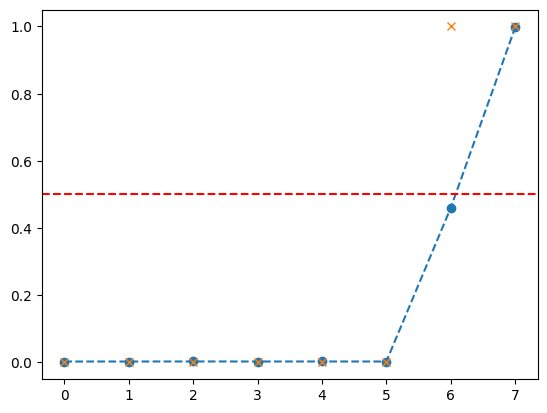

In [25]:
logits = np.array(
    [[ 2.7346244, -3.1177292],
     [ 2.7103324, -3.1362345],
     [ 2.7464483, -3.0521457],
     [ 2.7195318, -3.122628 ],
     [ 2.7138977, -3.1041346],
     [ 2.7398622, -3.1098123],
     [ 0.0657177, -0.0930362],
     [-2.7668718,  3.0918367]]
)
references = labels = np.array([0,0,0,0,0,0,1,1])
probabilities = torch.tensor(logits).softmax(dim=1).numpy()
prediction_scores = probabilities[:,1]
plt.plot(prediction_scores,'--o')
plt.plot(labels,'x')                # 노란색 x는 `labels`를 의미
plt.axhline(y=0.5,color='red',linestyle='--')
acc = evaluate.load("accuracy")
rec = evaluate.load("recall")
roc_auc = evaluate.load("roc_auc")
print(acc.compute(predictions=predictions,references=references))
print(rec.compute(predictions=predictions,references=references))
print(roc_auc.compute(prediction_scores=prediction_scores,references=references))

`예제2` - 시각화

{'accuracy': 0.875}
{'recall': 0.5}
{'roc_auc': 0.5833333333333333}


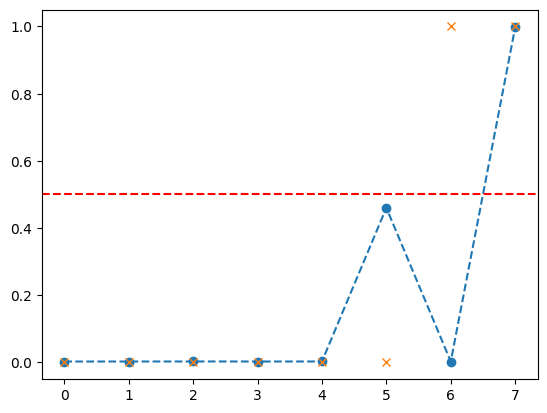

In [26]:
 logits = np.array(
    [[ 2.7346244, -3.1177292],
     [ 2.7103324, -3.1362345],
     [ 2.7464483, -3.0521457],
     [ 2.7195318, -3.122628 ],
     [ 2.7138977, -3.1041346],
     [ 0.0657177, -0.0930362],
     [ 2.7398622, -3.1098123],
     [-2.7668718,  3.0918367]]
)
references = labels = np.array([0,0,0,0,0,0,1,1])
probabilities = torch.tensor(logits).softmax(dim=1).numpy()
prediction_scores = probabilities[:,1]
plt.plot(prediction_scores,'--o')
plt.plot(labels,'x')
plt.axhline(y=0.5,color='red',linestyle='--')
acc = evaluate.load("accuracy")
rec = evaluate.load("recall")
roc_auc = evaluate.load("roc_auc")
print(acc.compute(predictions=predictions,references=references))
print(rec.compute(predictions=predictions,references=references))
print(roc_auc.compute(prediction_scores=prediction_scores,references=references))

위의 그래프는 빨간 점선을 잘 이동하면 괜찮을 거 같은데, 아래 그래프는 빨간 점선을 이동시킨다고 뭐 될 것 같지도 않음... → 아래 그래프의 `rou_auc`의 값이 현저히 작은 이유

# 분석

In [27]:
train_csv = pd.read_csv("./data/train.csv")
train_csv

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1
...,...,...
17495,ffede47a74e47a5930f81c0b6896479e.jpg,0
17496,ffef6382a50d23251d4bc05519c91037.jpg,1
17497,fff059ecc91b30be5745e8b81111dc7b.jpg,1
17498,fff43acb3b7a23edcc4ae937be2b7522.jpg,0


In [28]:
test_csv = pd.read_csv("./data/sample_submission.csv")
test_csv

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5
...,...,...
3995,ffaafd0c9f2f0e73172848463bc2e523.jpg,0.5
3996,ffae37344310a1549162493237d25d3f.jpg,0.5
3997,ffbd469c56873d064326204aac546e0d.jpg,0.5
3998,ffcb76b7d47f29ece11c751e5f763f52.jpg,0.5


## 잘 정리된 정석 코드(허깅페이스버전)

In [29]:
ctx_train = datasets.Dataset.from_pandas(train_csv)
ctx_test = datasets.Dataset.from_pandas(test_csv).remove_columns(['has_cactus'])

In [30]:
ctx_train

Dataset({
    features: ['id', 'has_cactus'],
    num_rows: 17500
})

In [31]:
ctx_test

Dataset({
    features: ['id'],
    num_rows: 4000
})

In [32]:
# ctx_test['path']

In [33]:
# `dataset`에 `path` 추가
# `id`는 이미지 이름. 즉, path와 id를 매핑함

ctx_train = ctx_train.map(lambda example: {'path': "./data/train/" + example['id']})
ctx_test = ctx_test.map(lambda example: {'path': "./data/test/" + example['id']})

Map:   0%|          | 0/17500 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

In [34]:
ctx = datasets.DatasetDict({
    'train':ctx_train,
    'test':ctx_test
})
ctx

DatasetDict({
    train: Dataset({
        features: ['id', 'has_cactus', 'path'],
        num_rows: 17500
    })
    test: Dataset({
        features: ['id', 'path'],
        num_rows: 4000
    })
})

In [35]:
ctx['train']['path'][0]

'./data/train/0004be2cfeaba1c0361d39e2b000257b.jpg'

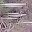

In [36]:
PIL.Image.open('./data/train/0004be2cfeaba1c0361d39e2b000257b.jpg')

💭이미지를 불러왔으니 다음 단계는 텐서화!

In [38]:
f = torchvision.transforms.ToTensor()

In [39]:
f(PIL.Image.open('./data/train/0004be2cfeaba1c0361d39e2b000257b.jpg'))

tensor([[[0.5333, 0.5255, 0.5804,  ..., 0.5961, 0.5725, 0.6118],
         [0.4863, 0.6314, 0.6235,  ..., 0.6392, 0.5765, 0.5686],
         [0.6314, 0.6275, 0.6235,  ..., 0.5882, 0.6314, 0.5059],
         ...,
         [0.5373, 0.7725, 0.4235,  ..., 0.6235, 0.5686, 0.6118],
         [0.5882, 0.6627, 0.5882,  ..., 0.6588, 0.5961, 0.5961],
         [0.7176, 0.4510, 0.6471,  ..., 0.7020, 0.5569, 0.5451]],

        [[0.5412, 0.5333, 0.5804,  ..., 0.5059, 0.4902, 0.5294],
         [0.4941, 0.6392, 0.6235,  ..., 0.5490, 0.4941, 0.4863],
         [0.6392, 0.6353, 0.6235,  ..., 0.5059, 0.5490, 0.4235],
         ...,
         [0.4353, 0.6706, 0.3333,  ..., 0.5176, 0.4627, 0.5059],
         [0.4863, 0.5608, 0.4863,  ..., 0.5451, 0.4824, 0.4824],
         [0.6157, 0.3490, 0.5451,  ..., 0.5882, 0.4431, 0.4314]],

        [[0.4902, 0.4824, 0.5490,  ..., 0.5294, 0.5098, 0.5490],
         [0.4431, 0.5882, 0.5922,  ..., 0.5725, 0.5137, 0.5059],
         [0.5882, 0.5843, 0.5922,  ..., 0.5255, 0.5686, 0.

In [40]:
g = torchvision.transforms.Resize(224)

In [41]:
g(f(PIL.Image.open('./data/train/0004be2cfeaba1c0361d39e2b000257b.jpg'))).shape

torch.Size([3, 224, 224])

💭이러한 전처리를 `Compose` 함수로 묶어버리자

In [42]:
# `compose` 함수는 이미지 주소로부터 사진을 읽은 다음, resize, tensor화 수행
# 즉, 입력 변수로 이미지 주소를 입력하면 됨

compose = torchvision.transforms.Compose([
    lambda path: PIL.Image.open(path),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((224,224))
])


# tensor화 해주는 과정
def w_trans(examples):
    # train: examples = {'id':[xx,xxx,....], 'has_cactus':[yy,yyy,...], 'path':[zz,zzz,...]}
    # train: examples = {'id':[xx,xxx,....], 'path':[zz,zzz,...]}
    dct = dict()
    dct['pixel_values'] = torch.stack(list(map(compose, examples['path'])))
    try:
        dct['labels']= torch.tensor(examples['has_cactus'])
    except:
        pass
    return dct

In [43]:
compose('./data/train/0004be2cfeaba1c0361d39e2b000257b.jpg')

tensor([[[0.5333, 0.5333, 0.5333,  ..., 0.6118, 0.6118, 0.6118],
         [0.5333, 0.5333, 0.5333,  ..., 0.6118, 0.6118, 0.6118],
         [0.5333, 0.5333, 0.5333,  ..., 0.6118, 0.6118, 0.6118],
         ...,
         [0.7176, 0.7176, 0.7176,  ..., 0.5451, 0.5451, 0.5451],
         [0.7176, 0.7176, 0.7176,  ..., 0.5451, 0.5451, 0.5451],
         [0.7176, 0.7176, 0.7176,  ..., 0.5451, 0.5451, 0.5451]],

        [[0.5412, 0.5412, 0.5412,  ..., 0.5294, 0.5294, 0.5294],
         [0.5412, 0.5412, 0.5412,  ..., 0.5294, 0.5294, 0.5294],
         [0.5412, 0.5412, 0.5412,  ..., 0.5294, 0.5294, 0.5294],
         ...,
         [0.6157, 0.6157, 0.6157,  ..., 0.4314, 0.4314, 0.4314],
         [0.6157, 0.6157, 0.6157,  ..., 0.4314, 0.4314, 0.4314],
         [0.6157, 0.6157, 0.6157,  ..., 0.4314, 0.4314, 0.4314]],

        [[0.4902, 0.4902, 0.4902,  ..., 0.5490, 0.5490, 0.5490],
         [0.4902, 0.4902, 0.4902,  ..., 0.5490, 0.5490, 0.5490],
         [0.4902, 0.4902, 0.4902,  ..., 0.5490, 0.5490, 0.

💭 `Dataset`에 이미지 주소(path)도 처음부터 들어있으면 좋을 거 같다

(사실 위에서 이미 `map` 기능을 수행함)

In [44]:
ctx = ctx.with_transform(w_trans)
ctx

DatasetDict({
    train: Dataset({
        features: ['id', 'has_cactus', 'path'],
        num_rows: 17500
    })
    test: Dataset({
        features: ['id', 'path'],
        num_rows: 4000
    })
})

In [45]:
# train에만 `labels`존재!
ctx['train'][:2]

{'pixel_values': tensor([[[[0.5333, 0.5333, 0.5333,  ..., 0.6118, 0.6118, 0.6118],
           [0.5333, 0.5333, 0.5333,  ..., 0.6118, 0.6118, 0.6118],
           [0.5333, 0.5333, 0.5333,  ..., 0.6118, 0.6118, 0.6118],
           ...,
           [0.7176, 0.7176, 0.7176,  ..., 0.5451, 0.5451, 0.5451],
           [0.7176, 0.7176, 0.7176,  ..., 0.5451, 0.5451, 0.5451],
           [0.7176, 0.7176, 0.7176,  ..., 0.5451, 0.5451, 0.5451]],
 
          [[0.5412, 0.5412, 0.5412,  ..., 0.5294, 0.5294, 0.5294],
           [0.5412, 0.5412, 0.5412,  ..., 0.5294, 0.5294, 0.5294],
           [0.5412, 0.5412, 0.5412,  ..., 0.5294, 0.5294, 0.5294],
           ...,
           [0.6157, 0.6157, 0.6157,  ..., 0.4314, 0.4314, 0.4314],
           [0.6157, 0.6157, 0.6157,  ..., 0.4314, 0.4314, 0.4314],
           [0.6157, 0.6157, 0.6157,  ..., 0.4314, 0.4314, 0.4314]],
 
          [[0.4902, 0.4902, 0.4902,  ..., 0.5490, 0.5490, 0.5490],
           [0.4902, 0.4902, 0.4902,  ..., 0.5490, 0.5490, 0.5490],
        

`model` 생성

In [46]:
model = transformers.AutoModelForImageClassification.from_pretrained(
    "microsoft/resnet-50",
    num_labels=2,
    ignore_mismatched_sizes=True,
)

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


`train`

In [47]:
single_batch = [ctx['train'][0],ctx['train'][1]]
single_batch # [{'pixel_values':xx, 'labels':yy},{'pixel_values':xxx, 'labels':yyy}]
data_collator = transformers.DefaultDataCollator()
data_collator(single_batch) # [{'pixel_values':xx, 'labels':yy},{'pixel_values':xxx, 'labels':yyy}] --> {'pixel_values':[xx,xxx], 'labels':[yy,yyy]}
model.to("cpu")
model(**data_collator(single_batch))

ImageClassifierOutputWithNoAttention(loss=tensor(0.6075, grad_fn=<NllLossBackward0>), logits=tensor([[-0.1037,  0.0792],
        [-0.0846,  0.0909]], grad_fn=<AddmmBackward0>), hidden_states=None)

In [48]:
data_collator = transformers.DefaultDataCollator()
data_collator

DefaultDataCollator(return_tensors='pt')

In [49]:
# 입력은 항상 `logits, labels`
# accuracy를 계산하고 싶을 때
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits,axis=1)
    predictions_scores = torch.tensor(logits).softmax(dim=1).numpy()[:,1]
    acc = evaluate.load("accuracy")
    rec = evaluate.load("recall")
    roc_auc = evaluate.load("roc_auc")
    dct1 = acc.compute(predictions = predictions, references = labels) # {'accuracy':???}
    dct2 = rec.compute(predictions = predictions, references = labels) # {'recall':???}
    dct3 = roc_auc.compute(prediction_scores = predictions_scores, references = labels) # {'roc_auc':???}
    return dct1|dct2|dct3# {'accuracy':얼마얼마, 'recall':얼마얼마, 'roc_auc':얼마얼마}

In [50]:
training_args = transformers.TrainingArguments(
    output_dir="asdf",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    report_to="none"
)
trainer = transformers.Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=ctx["train"].select(range(1000)),
    eval_dataset=ctx["train"].select(range(1000,1500)),
    compute_metrics=compute_metrics,
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Recall,Roc Auc
0,0.669000,0.642483,0.748000,1.000000,0.813697
1,0.619600,0.612107,0.746000,1.000000,0.811261
2,0.611200,0.592875,0.746000,1.000000,0.892956
3,0.592100,0.586050,0.744000,1.000000,0.909400


TrainOutput(global_step=60, training_loss=0.62042236328125, metrics={'train_runtime': 77.3638, 'train_samples_per_second': 51.704, 'train_steps_per_second': 0.776, 'total_flos': 8.103429948063744e+16, 'train_loss': 0.62042236328125, 'epoch': 3.8095238095238093})

`prediction`

In [52]:
out = trainer.predict(ctx['test'])
out

PredictionOutput(predictions=array([[-0.0746185 ,  0.06254058],
       [-0.08977754,  0.09996128],
       [-0.03843999,  0.09269745],
       ...,
       [-0.10998772,  0.10734566],
       [-0.11513144,  0.09273548],
       [-0.09639072,  0.12376897]], dtype=float32), label_ids=None, metrics={'test_runtime': 18.7308, 'test_samples_per_second': 213.552, 'test_steps_per_second': 13.347})

In [55]:
logits = out.predictions
has_cactus = torch.tensor(logits).softmax(dim=1).numpy()[:,1]

In [57]:
has_cactus

array([0.53423613, 0.5472929 , 0.5327375 , ..., 0.5541205 , 0.5517804 ,
       0.5548187 ], dtype=float32)

In [58]:
logits
# 💭out이랑 똑같은 거 같은디

array([[-0.0746185 ,  0.06254058],
       [-0.08977754,  0.09996128],
       [-0.03843999,  0.09269745],
       ...,
       [-0.10998772,  0.10734566],
       [-0.11513144,  0.09273548],
       [-0.09639072,  0.12376897]], dtype=float32)

In [59]:
test_csv['has_cactus'] = has_cactus
test_csv

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.534236
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.547293
2,001ee6d8564003107853118ab87df407.jpg,0.532737
3,002e175c3c1e060769475f52182583d0.jpg,0.539578
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.544709
...,...,...
3995,ffaafd0c9f2f0e73172848463bc2e523.jpg,0.546333
3996,ffae37344310a1549162493237d25d3f.jpg,0.550326
3997,ffbd469c56873d064326204aac546e0d.jpg,0.554120
3998,ffcb76b7d47f29ece11c751e5f763f52.jpg,0.551780


경진대회에서 이 파일을 제출하면 되는 거 같아여~~!!!!!

In [60]:
# train_csv = pd.read_csv("./data/train.csv")
# test_csv = pd.read_csv("./data/sample_submission.csv")
# #---#
# # Step1: Data
# ctx_train = datasets.Dataset.from_pandas(train_csv)
# ctx_test = datasets.Dataset.from_pandas(test_csv).remove_columns(['has_cactus'])
# ctx_train = ctx_train.map(lambda example: {'path': "./data/train/" + example['id']})
# ctx_test = ctx_test.map(lambda example: {'path': "./data/test/" + example['id']})
# ctx = datasets.DatasetDict({
#     'train':ctx_train,
#     'test':ctx_test
# })
# compose = torchvision.transforms.Compose([
#     lambda path: PIL.Image.open(path),
#     torchvision.transforms.ToTensor(),
#     torchvision.transforms.Resize((224,224))
# ])
# def w_trans(examples):
#     # train: examples = {'id':[xx,xxx,....], 'has_cactus':[yy,yyy,...], 'path':[zz,zzz,...]}
#     # train: examples = {'id':[xx,xxx,....], 'path':[zz,zzz,...]}
#     dct = dict()
#     dct['pixel_values'] = torch.stack(list(map(compose, examples['path'])))
#     try:
#         dct['labels']= torch.tensor(examples['has_cactus'])
#     except:
#         pass
#     return dct
# ctx = ctx.with_transform(w_trans)
# # Step2: Model
# model = transformers.AutoModelForImageClassification.from_pretrained(
#     "microsoft/resnet-50",
#     num_labels=2,
#     ignore_mismatched_sizes=True,
# )
# # Step3: Train
# data_collator = transformers.DefaultDataCollator()
# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits,axis=1)
#     predictions_scores = torch.tensor(logits).softmax(dim=1).numpy()[:,1]
#     acc = evaluate.load("accuracy")
#     rec = evaluate.load("recall")
#     roc_auc = evaluate.load("roc_auc")
#     dct1 = acc.compute(predictions = predictions, references = labels) # {'accuracy':???}
#     dct2 = rec.compute(predictions = predictions, references = labels) # {'recall':???}
#     dct3 = roc_auc.compute(prediction_scores = predictions_scores, references = labels) # {'roc_auc':???}
#     return dct1|dct2|dct3# {'accuracy':???, 'recall':???, 'roc_auc':???}
# training_args = transformers.TrainingArguments(
#     output_dir="asdf",
#     remove_unused_columns=False,
#     eval_strategy="epoch",
#     save_strategy="epoch",
#     learning_rate=5e-5,
#     per_device_train_batch_size=16,
#     gradient_accumulation_steps=4,
#     per_device_eval_batch_size=16,
#     num_train_epochs=4,
#     warmup_ratio=0.1,
#     logging_steps=10,
#     load_best_model_at_end=True,
#     metric_for_best_model="roc_auc",
#     push_to_hub=False,
#     report_to="none"
# )
# trainer = transformers.Trainer(
#     model=model,
#     args=training_args,
#     data_collator=data_collator,
#     train_dataset=ctx["train"].select(range(1000)),
#     eval_dataset=ctx["train"].select(range(1000,1500)),
#     compute_metrics=compute_metrics,
# )
# trainer.train()
# # Step4: Prediction
# out = trainer.predict(ctx['test'])
# logits = out.predictions
# has_cactus = torch.tensor(logits).softmax(dim=1).numpy()[:,1]
# test_csv['has_cactus']= has_cactus

# 자유로운 코드

`Dataset` 로드

In [61]:
train_csv = pd.read_csv("./data/train.csv")
test_csv = pd.read_csv("./data/sample_submission.csv")
train_csv2 = pd.read_csv("./data/train.csv")
test_csv2 = pd.read_csv("./data/sample_submission.csv")

In [69]:
train_csv

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1
...,...,...
17495,ffede47a74e47a5930f81c0b6896479e.jpg,0
17496,ffef6382a50d23251d4bc05519c91037.jpg,1
17497,fff059ecc91b30be5745e8b81111dc7b.jpg,1
17498,fff43acb3b7a23edcc4ae937be2b7522.jpg,0


💭 예전에는 `Dataset`으로 먼저 만들고 `path`를 만들었는데, `path` 먼저 만들고 `Dataset`으로 변환해도 되지 않을까?

In [62]:
train_csv2['path'] = ['./data/train/'+l for l in train_csv.id]
test_csv2['path'] = ['./data/test/'+l for l in test_csv.id]
train_csv2 = train_csv2.loc[:,['has_cactus','path']]
test_csv2 = test_csv2.loc[:,['path']]

In [65]:
train_csv2

,has_cactus,path
0,1,./data/train/0004be2cfeaba1c0361d39e2b000257b.jpg
1,1,./data/train/000c8a36845c0208e833c79c1bffedd1.jpg
2,1,./data/train/000d1e9a533f62e55c289303b072733d.jpg
3,1,./data/train/0011485b40695e9138e92d0b3fb55128.jpg
4,1,./data/train/0014d7a11e90b62848904c1418fc8cf2.jpg
...,...,...
17495,0,./data/train/ffede47a74e47a5930f81c0b6896479e.jpg
17496,1,./data/train/ffef6382a50d23251d4bc05519c91037.jpg
17497,1,./data/train/fff059ecc91b30be5745e8b81111dc7b.jpg
17498,0,./data/train/fff43acb3b7a23edcc4ae937be2b7522.jpg


In [63]:
ctx = datasets.DatasetDict(
    {
        'train': datasets.Dataset.from_pandas(train_csv2),
        'test':datasets.Dataset.from_pandas(test_csv2)
    }
)
ctx

DatasetDict({
    train: Dataset({
        features: ['has_cactus', 'path'],
        num_rows: 17500
    })
    test: Dataset({
        features: ['path'],
        num_rows: 4000
    })
})

In [71]:
model = transformers.AutoModelForImageClassification.from_pretrained(
    "microsoft/resnet-50",
    num_labels=2,
    ignore_mismatched_sizes=True,
)

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [72]:
single_batch =  [ctx['train'][0], ctx['train'][1]]
single_batch

[{'has_cactus': 1,
  'path': './data/train/0004be2cfeaba1c0361d39e2b000257b.jpg'},
 {'has_cactus': 1,
  'path': './data/train/000c8a36845c0208e833c79c1bffedd1.jpg'}]

In [73]:
compose = torchvision.transforms.Compose([
    lambda path: PIL.Image.open(path),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((224,224))
])

In [74]:
def collate_fn(single_batch):
    dct = dict()
    dct['pixel_values'] = torch.stack([compose(o['path']) for o in single_batch])
    try:
        dct['labels'] = torch.tensor([o['has_cactus'] for o in single_batch])
    except:
        pass
    return dct

In [78]:
def collate_fn(single_batch):
    dct = dict()
    dct['pixel_values'] = torch.stack([compose(o['path']) for o in single_batch]) # 3차원 이상이니까 `stack`필수
    try: # `train`이라서 `labels=has_cactus` 가 있을 때
        dct['labels'] = torch.tensor([o['has_cactus'] for o in single_batch])
    except:  # `test`라서 `labels=has_cactus` 가 없을 때
        pass
    return dct

In [79]:
model(**collate_fn(single_batch))

ImageClassifierOutputWithNoAttention(loss=tensor(0.7630, grad_fn=<NllLossBackward0>), logits=tensor([[ 0.1178, -0.0005],
        [ 0.1930,  0.0410]], grad_fn=<AddmmBackward0>), hidden_states=None)

In [80]:
# train_csv = pd.read_csv("./data/train.csv")
# test_csv = pd.read_csv("./data/sample_submission.csv")
# train_csv2 = pd.read_csv("./data/train.csv")
# test_csv2 = pd.read_csv("./data/sample_submission.csv")
# #---#
# # Step1: Data
# train_csv2['path'] = ['./data/train/'+l for l in train_csv.id]
# test_csv2['path'] = ['./data/test/'+l for l in test_csv.id]
# train_csv2 = train_csv2.loc[:,['has_cactus','path']]
# test_csv2 = test_csv2.loc[:,['path']]
# ctx = datasets.DatasetDict(
#     {
#         'train': datasets.Dataset.from_pandas(train_csv2),
#         'test':datasets.Dataset.from_pandas(test_csv2)
#     }
# )
# # Step2: Model
# model = transformers.AutoModelForImageClassification.from_pretrained(
#     "microsoft/resnet-50",
#     num_labels=2,
#     ignore_mismatched_sizes=True,
# )
# # Step3: Train
# def collate_fn(single_batch):
#     dct = dict()
#     dct['pixel_values'] = torch.stack([compose(o['path']) for o in single_batch])
#     try:
#         dct['labels'] = torch.tensor([o['has_cactus'] for o in single_batch])
#     except:
#         pass
#     return dct
# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits,axis=1)
#     predictions_scores = torch.tensor(logits).softmax(dim=1).numpy()[:,1]
#     acc = evaluate.load("accuracy")
#     rec = evaluate.load("recall")
#     roc_auc = evaluate.load("roc_auc")
#     dct1 = acc.compute(predictions = predictions, references = labels) # {'accuracy':???}
#     dct2 = rec.compute(predictions = predictions, references = labels) # {'recall':???}
#     dct3 = roc_auc.compute(prediction_scores = predictions_scores, references = labels) # {'roc_auc':???}
#     return dct1|dct2|dct3# {'accuracy':???, 'recall':???, 'roc_auc':???}
# training_args = transformers.TrainingArguments(
#     output_dir="asdf",
#     remove_unused_columns=False,
#     eval_strategy="epoch",
#     save_strategy="epoch",
#     learning_rate=5e-5,
#     per_device_train_batch_size=16,
#     gradient_accumulation_steps=4,
#     per_device_eval_batch_size=16,
#     num_train_epochs=4,
#     warmup_ratio=0.1,
#     logging_steps=10,
#     load_best_model_at_end=True,
#     metric_for_best_model="roc_auc",
#     push_to_hub=False,
#     report_to="none"
# )
# trainer = transformers.Trainer(
#     model=model,
#     args=training_args,
#     data_collator=collate_fn,
#     train_dataset=ctx["train"].select(range(1000)),
#     eval_dataset=ctx["train"].select(range(1000,1500)),
#     compute_metrics=compute_metrics,
# )
# trainer.train()
# # Step4: Prediction
# out = trainer.predict(ctx['test'])
# logits = out.predictions
# has_cactus = torch.tensor(logits).softmax(dim=1).numpy()[:,1]
# test_csv['has_cactus']= has_cactus